In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis")

Skipping, found downloaded files in "./chest-xray-pneumoniacovid19tuberculosis" (use force=True to force download)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

###**Checking Directories**

In [3]:
# Directories containing the dataset
train_dir = '/content/chest-xray-pneumoniacovid19tuberculosis/train'
test_dir = '/content/chest-xray-pneumoniacovid19tuberculosis/test'
val_dir = '/content/chest-xray-pneumoniacovid19tuberculosis/val'

In [4]:
import os

for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 4 directories and 0 images in '/content/chest-xray-pneumoniacovid19tuberculosis/train'
There are 0 directories and 1341 images in '/content/chest-xray-pneumoniacovid19tuberculosis/train/NORMAL'
There are 0 directories and 3875 images in '/content/chest-xray-pneumoniacovid19tuberculosis/train/PNEUMONIA'
There are 0 directories and 460 images in '/content/chest-xray-pneumoniacovid19tuberculosis/train/COVID19'
There are 0 directories and 650 images in '/content/chest-xray-pneumoniacovid19tuberculosis/train/TURBERCULOSIS'


In [5]:
# Checking class names
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [6]:
print(class_names)

['COVID19' 'NORMAL' 'PNEUMONIA' 'TURBERCULOSIS']


In [7]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f"Image shape: {img.shape}")

Image shape: (1480, 1762)


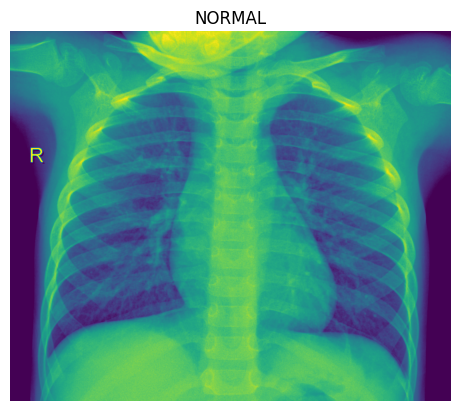

In [8]:
view_random_image('/content/chest-xray-pneumoniacovid19tuberculosis/train/', 'NORMAL')

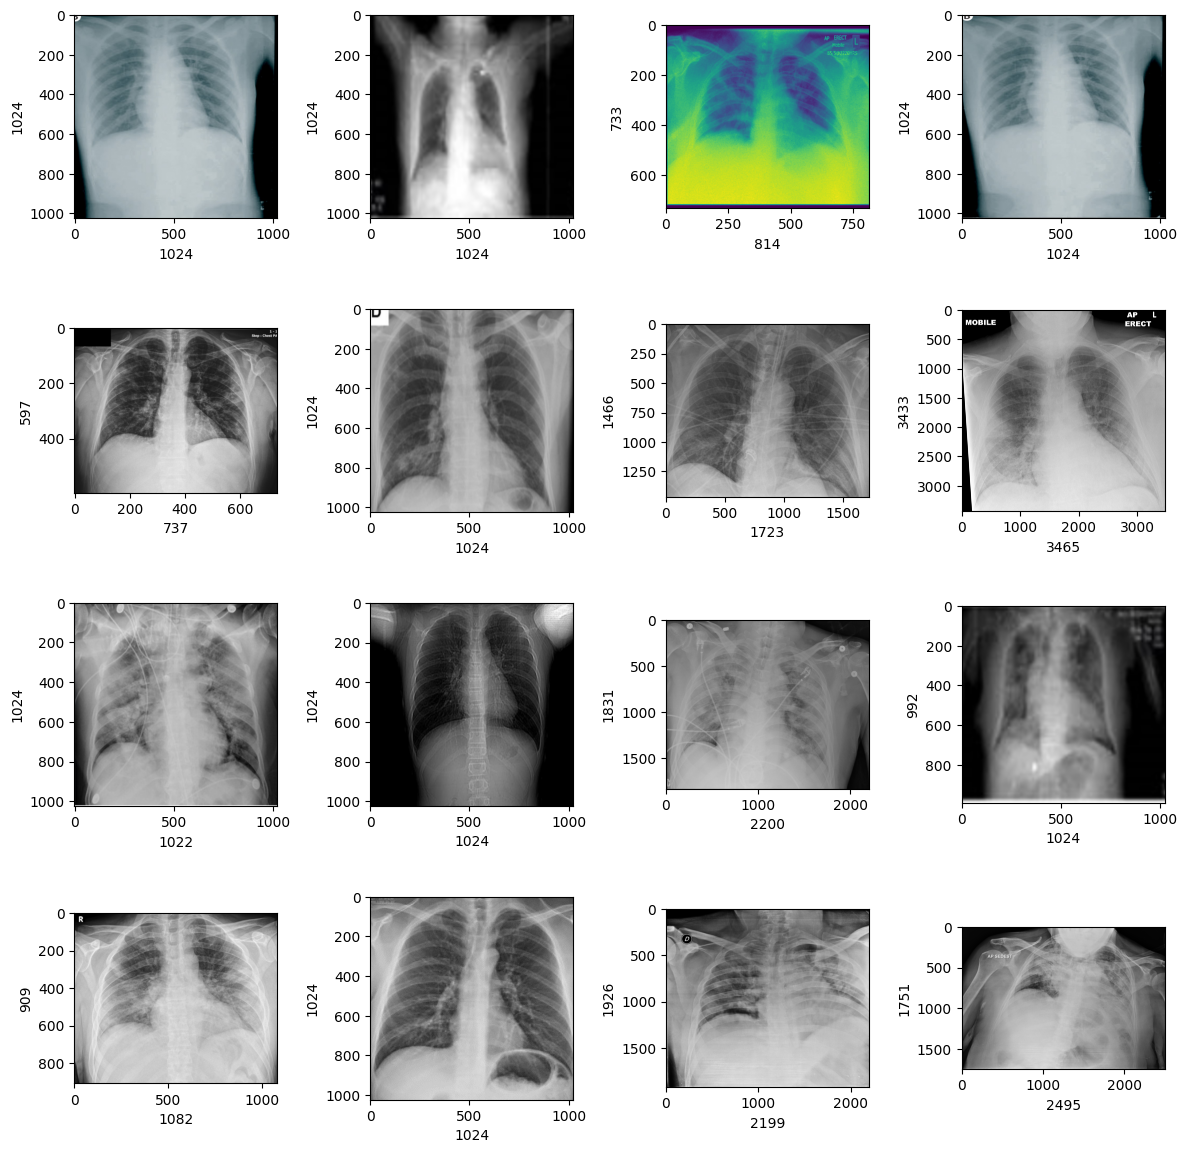

In [9]:
plt.figure(figsize = (12, 12))
path = '/content/chest-xray-pneumoniacovid19tuberculosis/train/COVID19'
for i in range(1, 17):
  plt.subplot(4, 4, i)
  plt.tight_layout()
  rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

In [10]:
# Hyperparameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 20
num_classes = 4

In [11]:
# Load the datasets without validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 6326 files belonging to 4 classes.
Found 38 files belonging to 4 classes.
Found 771 files belonging to 4 classes.


In [12]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [13]:
# Apply data augmentation only to the training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
# Prefetch the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

##**Model Building**

In [15]:
def VGG16(input_shape = (224, 224, 3), num_classes = 4):
  model = models.Sequential()

  # Add Input Layer
  model.add(layers.Input(shape = input_shape))

  # Normalization layer
  model.add(layers.Rescaling(1./255))

  # Block 1
  model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2), strides = (2, 2)))

  # Block 2
  model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2), strides = (2, 2)))

  # Block 3
  model.add(layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.Conv2D(256, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2), strides = (2, 2)))

  # Block 4
  model.add(layers.Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.Conv2D(512, (3, 3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2), strides = (2, 2)))

  # Fully connected layers
  model.add(layers.Flatten())

  model.add(layers.Dense(4096, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation = 'softmax'))

  return model

In [16]:
model = VGG16()

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     411,045,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 435,478,852 (1.62 GB)

 Trainable params: 435,478,852 (1.62 GB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = 5
)

Epoch 1/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.5833 - loss: 3.9313 - val_accuracy: 0.2105 - val_loss: 1.8707
Epoch 2/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 152s 766ms/step - accuracy: 0.6164 - loss: 1.0537 - val_accuracy: 0.2105 - val_loss: 1.8665
Epoch 3/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 218s 845ms/step - accuracy: 0.6160 - loss: 1.0501 - val_accuracy: 0.2105 - val_loss: 1.8115
Epoch 4/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 187s 770ms/step - accuracy: 0.6175 - loss: 1.0479 - val_accuracy: 0.2105 - val_loss: 1.8763
Epoch 5/5
198/198 ━━━━━━━━━━━━━━━━━━━━ 196s 742ms/step - accuracy: 0.6163 - loss: 1.0491 - val_accuracy: 0.2105 - val_loss: 1.8603


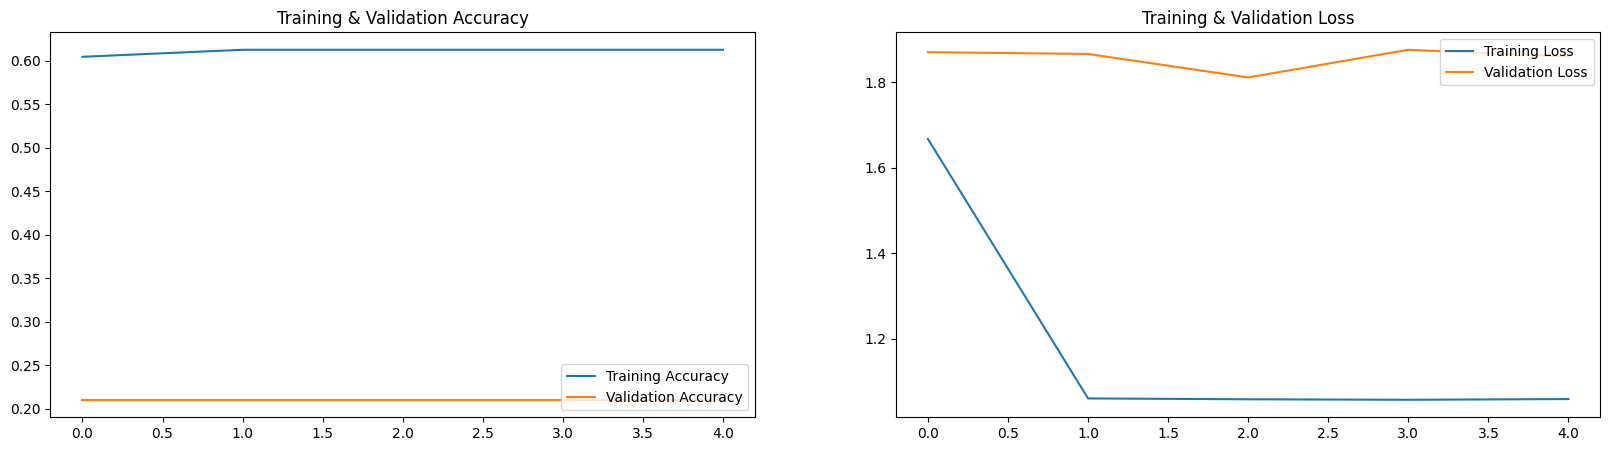

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training & Validation Loss")
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {(test_accuracy) * 100:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 725ms/step - accuracy: 0.5028 - loss: 1.1989
Test Loss: 1.191598892211914
Test Accuracy: 50.58


In [22]:
# Train set predictions
y_train_true = np.concatenate([y for x, y in train_dataset], axis=0)
y_train_pred = model.predict(train_dataset)
y_train_pred = np.argmax(y_train_pred, axis=1)

# Validation set predictions
y_val_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_val_pred = model.predict(validation_dataset)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Test set predictions
y_test_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_test_pred = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_pred, axis=1)

198/198 ━━━━━━━━━━━━━━━━━━━━ 105s 517ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step


In [23]:
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)


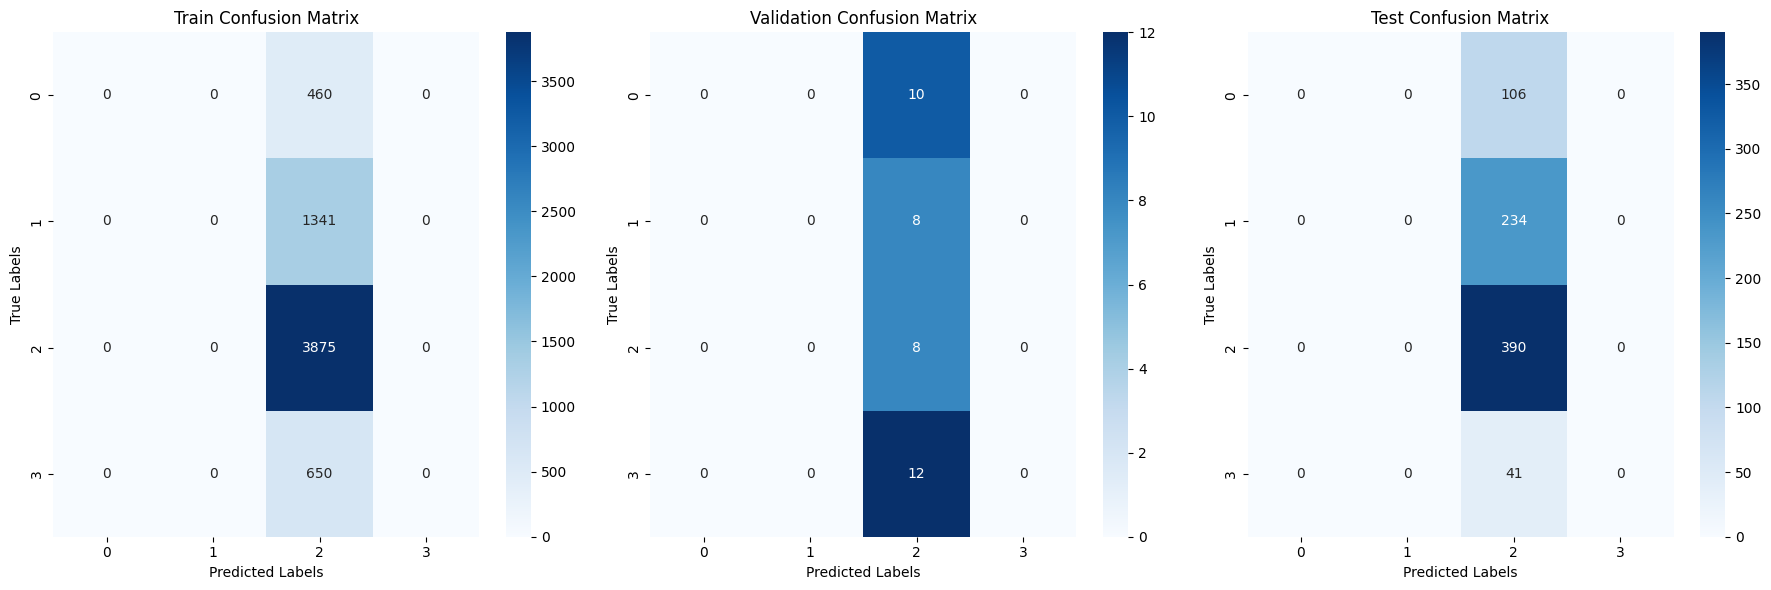

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train Confusion Matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Validation Confusion Matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Test Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

# Adjust layout
plt.tight_layout()
plt.show()